In [1]:
import time, sys

import pandas as pd

sys.path.append('/home/yilingh/SI-Interaction')
import multiprocessing as mp

from selectinf.Simulation.simulation_helpers import (
    generate_gaussian_instance_nonlinear_interaction_simple)

from selectinf.group_lasso_query import (group_lasso)
from selectinf.Simulation.simulation_helpers import (naive_inference_inter,
                                                     data_splitting_inter,
                                                     MLE_inference_inter)
from selectinf.Simulation.plotting_helpers import *
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [2]:
from operator import le, ge
def filter_pval_dict_new(target_dict, threshold=0.05, operator=le, p_flag="pivot"):
    grouped_targets = pd.DataFrame(target_dict).groupby(['parameter', 'method'])
    filtered_dict = {}
    # Filter by 
    for name, group in grouped_targets:
        # Subset the selected targets
        selected_targets_id = operator(np.abs(group['target']), threshold)
        selected_targets = group[p_flag][selected_targets_id]
        # Then filtered_dict.keys must be a dictionary
        if name[0] in filtered_dict.keys():
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        else:
            filtered_dict[name[0]] = {}
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        
    return filtered_dict

In [3]:
args = [(i*2, (i+1)*2) for i in range(4)]
with mp.Pool(processes=4) as pool:
    results = pool.starmap(vary_SNR, args)

0 th simulation done
Equally spaced quantile knots used.
Main: 0.030202882791452983
Interaction: 0.03883754530673402
induced SNR: 0.5000000000000001
Naive Selected Groups: 3
4 th simulation done
Equally spaced quantile knots used.
Main: 0.031052405288407196
Interaction: 0.03788402612469581
induced SNR: 0.5000000000000001
Naive Selected Groups: 3
2 th simulation done
Equally spaced quantile knots used.
Main: 0.030620991574208733
Interaction: 0.039345719114207915
induced SNR: 0.5000000000000001
Naive Selected Groups: 3
6 th simulation done
Equally spaced quantile knots used.
Main: 0.03201977712488291
Interaction: 0.03924146378123024
induced SNR: 0.5000000000000001
Naive Selected Groups: 3



KeyboardInterrupt



In [ ]:
oper_char, pval_dict, target_dict = vary_SNR(0,10)

In [ ]:
pd.DataFrame(oper_char)

In [ ]:
pd.DataFrame(target_dict)

In [ ]:
pval_dict

In [4]:
def filter_pval_dict(pval_dict, target_dict, threshold=0.05):
    target_dict_df = pd.DataFrame(target_dict)
    filtered_dict = {}
    for par in pval_dict.keys():
        filtered_dict[par] = {}
        par_dict = pval_dict[par]
        target_df_par = target_dict_df[target_dict_df['parameter'] == par]
        
        for method in par_dict.keys():
            targets_p_m = (target_df_par[target_df_par['method'] == method])['target']
            selected_targets = (np.abs(targets_p_m) < threshold)
            pvals_p_m = np.array(pval_dict[par][method])
            filtered_dict[par][method] = pvals_p_m[selected_targets].tolist()
    
    return filtered_dict
        

In [ ]:
## Plotting dict: SNR - Method - List of pvals
filtered_dict = filter_pval_dict(pval_dict, target_dict)

In [ ]:
plot_ecdfs(filtered_dict, xaxis="SNR")

In [ ]:
list_of_oper = [tup[0] for tup in results]

In [ ]:
list_of_pval = [tup[1] for tup in results]

In [ ]:
list_of_targets = [tup[2] for tup in results]

In [ ]:
plot_ecdfs(combine_nested_lists(list_of_pval), xaxis="SNR")

# Plot boxplots of projected targets

In [ ]:
plot_multi_targets(combine_lists(list_of_targets), xaxis="SNR")

In [ ]:
point_plot_multimetrics(oper_char_df=pd.DataFrame(combine_lists(list_of_oper)),
                        x_axis="SNR",
                        hue="method",
                        metric_list=["power"])

# Fix Interaction Signal, Vary Main

In [37]:
# A dictionary recording simulation results and metrics
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho"] = []
oper_char["signal"] = []
oper_char["main signal"] = []
oper_char["target"] = []
oper_char["power"] = []

# Dictionary of projected targets, over all simulation parameters
target_dict = {}
target_dict["parameter"] = []
target_dict["target"] = []
target_dict["target id"] = []
target_dict["method"] = []
target_dict["index"] = []
target_dict["pivot"] = []
target_dict["pval"] = []

# A dictionary recording p-values for each true interaction
# over all simulation results.
# Each simulation parameter (here parameter_list contain a list of main signal strengths 
# to be considered) has a corresponding dictionary of results
parameter_list = np.array([2, 1])#np.array([10, 5, 2, 1])
pval_dict = {}
for x in parameter_list:
    pval_dict[x] = {}
    for m in ['Naive', 'Data Splitting', 'MLE']:
        pval_dict[x][m] = []

# Group lasso solver constructor
const = group_lasso.gaussian
active_inter_list_true = np.array([[0,1], [1,2], [2,4], [1,5], [2,6]])
active_inter_list_true_list = [(x[0],x[1]) for x in active_inter_list_true]

#p = 50
rho = 0.5 # Correlation of signal covariates (amongst themselves), and noise.
sig = 2 # Controlling interaction vs main signals. 
           # Setting it this way generates comparable main 
           # and interaction signals
weights = 0.05 # Group Lasso weights
s_inter = 5 # Number of true interactions
p_nl = 20 # Number of nonlinear covariates
n=100
root_n_scaled = False

for i in range(200):
    print(i,"th simulation done")
    #for rho in [0.25, 0.5, 0.75]:
    #for sig in [0.1, 0.25, 0.5, 1]:
    #for SNR in [0.1, 0.25, 0.5, 1]:
    for main_sig in parameter_list:
        print(main_sig, i,"th simulation done")
        while True:
            # Generating a (X, Y) pair, and corresponding basis expansion
            # The 'weakhierarchy' argument is overridden by setting 
            # `active_inter_list`.
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=n, p_nl=p_nl, rho=rho, full_corr=False, rho_noise=rho,
                    SNR = None, main_signal=main_sig, noise_sd=10,
                    nknots = 6, degree = 2, interaction_signal=sig,
                    random_signs=False, scale=root_n_scaled, center=False,
                    structure='weakhierarchy', s_interaction=s_inter,
                    intercept=True, active_inter_list=active_inter_list_true, 
                    return_gamma=True))
            print("SD(Y): ", np.std(Y))
            
            # Performing Naive inference using 'all pairs'
            coverages, lengths, selected_inter, p_values, pivots, targets, idx \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9, mode='weakhierarchy',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True, 
                                        return_pivot=True, intercept=True, 
                                        target_ids=active_inter_list_true_list,
                                           root_n_scaled=root_n_scaled)
            
            noselection = coverages is None
            
            # Continue if Naive yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing data splitting using 'all pairs'
                (coverages_ds, lengths_ds, selected_inter_ds, 
                 p_values_ds, pivots_ds, targets_ds, idx_ds) \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                           Y_mean=Y_mean, const=const,
                                           n_features=20, interactions=data_interaction,
                                           proportion=0.67,
                                           weight_frac=weights, level=0.9, 
                                           mode='weakhierarchy',
                                           solve_only=False, continued=False, 
                                           parallel=False, p_val=True, 
                                           target_ids=active_inter_list_true_list,
                                           root_n_scaled=root_n_scaled)
                noselection = coverages_ds is None
            
            # Continue if data splitting yields a nonempty group lasso selection
            # (this is almost always the case)    
            if not noselection:
                # Performing MLE using 'all pairs'
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, pivots_MLE, targets_MLE, idx_MLE\
                    = (MLE_inference_inter
                       (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                        n_features=p_nl, interactions=data_interaction,
                        intercept=True, 
                        #randomizer_sd_const=0.02, 
                        proportion=0.67,
                        weight_frac=weights,
                        level=0.9, mode='weakhierarchy', solve_only=False, 
                        continued=False, parallel=False, p_val=True, 
                        target_ids=active_inter_list_true_list,
                        root_n_scaled=root_n_scaled))
                noselection = coverages_MLE is None
            
            # Collect results if all three methods yields 
            # nonempty first-stage selection
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["signal"].append(sig)
                oper_char["main signal"].append(main_sig)
                oper_char["rho"].append(rho)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets[0])
                pval_dict[main_sig]['Naive'] += (p_values)
                oper_char["power"].append(calculate_power(p_values, targets, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets, parameter=main_sig,
                               method="Naive", idx=idx,
                                   pvals=p_values,
                                   pivots=pivots, sim_idx=i)
    
                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["signal"].append(sig)
                oper_char["main signal"].append(main_sig)
                oper_char["rho"].append(rho)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_ds[0])
                pval_dict[main_sig]['Data Splitting'] += (p_values_ds)
                oper_char["power"].append(calculate_power(p_values_ds, targets_ds, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_ds, parameter=main_sig,
                               method="Data Splitting", idx=idx_ds,
                                   pvals=p_values_ds,
                                   pivots=pivots_ds, sim_idx=i)
    
                
                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["signal"].append(sig)
                oper_char["main signal"].append(main_sig)
                oper_char["rho"].append(rho)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_MLE[0])
                pval_dict[main_sig]['MLE'] += (p_values_MLE)
                oper_char["power"].append(calculate_power(p_values_MLE, 
                                                          targets_MLE,
                                                          0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_MLE, parameter=main_sig,
                               method="MLE", idx=idx_MLE,
                                   pvals=p_values_MLE,
                                   pivots=pivots_MLE, sim_idx=i)
                
                break

0 th simulation done
2 0 th simulation done
Equally spaced quantile knots used.
Main: 1.4469925306905915
Interaction: 1.9554633921545492
induced SNR: 0.09350598988459688
SD(Y):  9.386361879414668
Naive Selected Groups: 9
DS Selected Groups: 9
Data Carving Randomization Used
MLE Selected Groups: 7
1 0 th simulation done
Equally spaced quantile knots used.
Main: 0.731570563963024
Interaction: 1.9073371660394836
induced SNR: 0.058499399853522434
SD(Y):  10.833295116259977
Naive Selected Groups: 4
DS Selected Groups: 6
Data Carving Randomization Used
MLE Selected Groups: 4
1 th simulation done
2 1 th simulation done
Equally spaced quantile knots used.
Main: 1.5326604766413012
Interaction: 2.2058252413003885
induced SNR: 0.11422522863012342
SD(Y):  10.483404601187448
Naive Selected Groups: 10
DS Selected Groups: 5
Data Carving Randomization Used
MLE Selected Groups: 6
1 1 th simulation done
Equally spaced quantile knots used.
Main: 0.7399832441515793
Interaction: 1.8141675653211253
induced 

In [38]:
# Safety checkpoint
target_dict_vary_main = target_dict

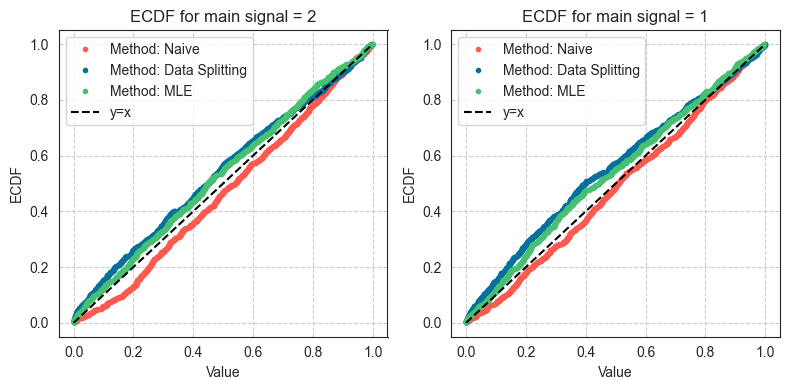

In [39]:
plot_ecdfs(pval_dict, xaxis="main signal")

In [40]:
## Plotting dict: SNR - Method - List of pvals
## Plotting dict: SNR - Method - List of pvals
filtered_dict = filter_pval_dict_new(target_dict, threshold = 0,
                                 operator=ge)

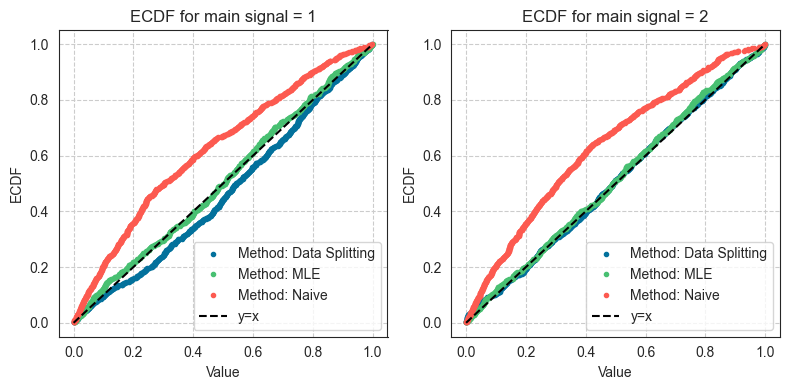

In [41]:
plot_ecdfs(filtered_dict, xaxis="main signal")

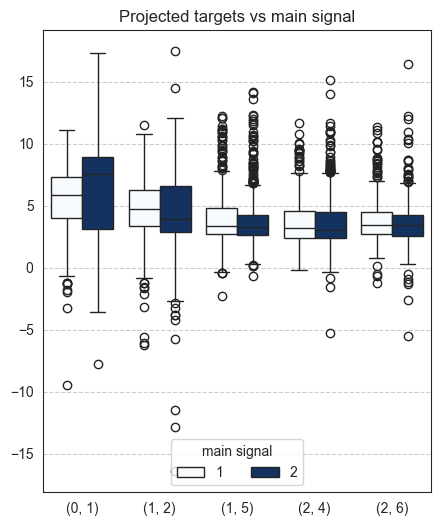

In [42]:
plot_multi_targets(target_dict, xaxis="main signal")

# Applying BY Correction to the p-values

In [43]:
from collections import defaultdict
from scipy.stats import false_discovery_control


def add_BY_pval_by_method_and_index(data):
    # Check if BYpval is there
    if "BYpval" in data.keys():
        return
    # Assuming your dictionary is named 'data' and structured as described
    methods = data['method']
    indices = data['index']
    pvals = data['pval']

    # Initialize default dictionaries to collect p-values and positions for each (method, index) pair
    pvals_dict = defaultdict(list)
    pos_dict = defaultdict(list)

    # Iterate over the data and populate the dictionaries
    for i, (method, index, pval) in enumerate(zip(methods, indices, pvals)):
        key = (method, index)
        pvals_dict[key].append(pval)
        pos_dict[key].append(i)

    # Initialize BYpvals array with the same length as pvals
    BYpvals = [0] * len(pvals)  # or use numpy.zeros_like(pvals) if pvals is a numpy array

    # Apply BY correction and assign back to positions
    for key in pvals_dict:
        pvals_list = pvals_dict[key]
        positions = pos_dict[key]
        corrected_pvals = false_discovery_control(pvals_list, method='by')
        for pos, by_pval in zip(positions, corrected_pvals):
            BYpvals[pos] = by_pval

    # Add BYpvals to the original data dictionary
    data['BYpvals'] = BYpvals

    # Now, pvals_dict contains lists of p-values for each unique (method, index) pair

In [44]:
add_BY_pval_by_method_and_index(target_dict)

# Calculating Thresholded Power

In [45]:
def calculate_thresholded_power(pvalue, targets, level, threshold=0.05,
                                operator=ge):
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = operator(np.abs(targets), threshold)
    rejection = pvalue < level
    if np.sum(non_null) == 0:
        return 0
    else:
        true_rej = np.sum(non_null * rejection) / np.sum(non_null)

    return true_rej

def calculate_thresholded_power_df(targets_dict,
                                   threshold=0.1,
                                   level=0.1,
                                   operator=ge, 
                                   pval_key = "BYpvals"):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    power_df['thresholded power'] = []
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        power_df['thresholded power'].append(
            calculate_thresholded_power(pvalues, targets, level=level, 
                                        threshold=threshold, operator=operator))
    return power_df

In [46]:
def point_plot_power(oper_char_dfs, x_axis='p', hue='method', 
                     ylim_low=None, ylim_high=None, exclude_naive=True,
                     randomizer_scales=None):
    for i in range(len(oper_char_dfs)):
        oper_char_dfs[i] = oper_char_dfs[i].copy()
        if exclude_naive:
            oper_char_dfs[i] = oper_char_dfs[i][oper_char_dfs[i]['method'] != "Naive"]
    sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })
    # sns.histplot(oper_char_df["sparsity size"])
    # plt.show()
    n_subplots = len(oper_char_dfs)
    # cols = int(np.ceil(n_subplots / 2))
    cols = n_subplots

    fig = plt.figure(figsize=(cols * 5, 6))

    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    # Create each subplot
    for i in range(1, n_subplots + 1):
        # ax = fig.add_subplot(2, cols, i) #two rows
        ax = fig.add_subplot(1, cols, i)  # one row
        if hue is not None:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          hue=oper_char_dfs[i-1][hue],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
            ax.set_title("Randomizer Scale:" + str(randomizer_scales[i-1]))
        else:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
        if ylim_low is not None and ylim_high is not None:
            ax.set_ylim([ylim_low, ylim_high])

        ax.legend().set_visible(False)

    handles, labels = ax.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)

    fig.subplots_adjust(bottom=0.3)
    fig.legend(handles, labels, loc='lower center', ncol=n_subplots,
               prop={'size': 15})

    # cov_plot.legend_.remove()
    # len_plot.legend_.remove()

    # plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [47]:
power_threshold = 0.1
power_df1 = calculate_thresholded_power_df(targets_dict=target_dict, 
                                           threshold=power_threshold, level=0.1,
                                           operator=ge, pval_key="BYpvals")

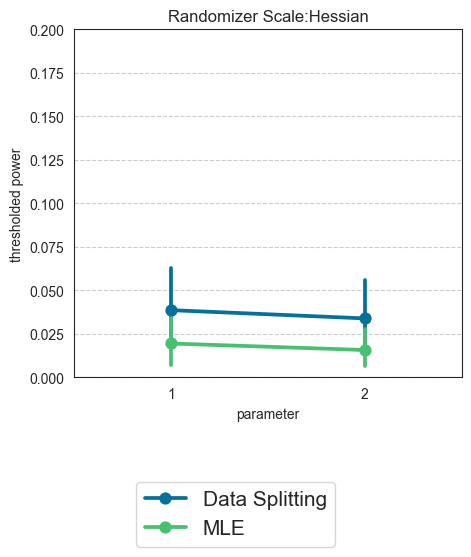

In [49]:
point_plot_power(oper_char_dfs=[pd.DataFrame(power_df1)],
                 x_axis="parameter",
                 hue="method", ylim_high=0.2, ylim_low=0,
                 randomizer_scales=["Hessian"])

# Vary Correlation between Signal and Noise

In [ ]:
# A dictionary recording simulation results and metrics
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho cross"] = []
oper_char["signal"] = []
#oper_char["SNR"] = []
oper_char["target"] = []
oper_char["power"] = []

# A dictionary recording p-values for each true interaction
# over all simulation results.
# Each simulation parameter (here parameter_list contain a list of correlations 
# to be considered) has a corresponding dictionary of results
parameter_list = [0, 0.15, 0.3, 0.45]
pval_dict = {}
for x in parameter_list:
    pval_dict[x] = {}
    for m in ['Naive', 'Data Splitting', 'MLE']:
        pval_dict[x][m] = []

# Dictionary of projected targets, over all simulation parameters
target_dict = {}
target_dict["parameter"] = []
target_dict["target"] = []
target_dict["target id"] = []
target_dict["method"] = []

# Group lasso solver constructor   
const = group_lasso.gaussian

# List and array representations of true interaction indices
active_inter_list_true = np.array([[0,1], [1,2], [2,4], [1,5], [2,6]])
active_inter_list_true_list = [(x[0],x[1]) for x in active_inter_list_true]

#p = 50
rho = 0.5 # Correlation of signal covariates (amongst themselves), and noise.
sig = 0.01 # Controlling interaction vs main signals. 
           # Setting it this way generates comparable main 
           # and interaction signals
weights = 2 # Group Lasso weights
s_inter = 5 # Number of true interactions
p_nl = 20 # Number of nonlinear covariates

for i in range(100):
    print(i,"th simulation done")
    #for rho in [0.25, 0.5, 0.75]:
    #for sig in [0.1, 0.25, 0.5, 1]:
    #for SNR in [0.1, 0.25, 0.5, 1]:
    for rho_cross in parameter_list:
        while True:
            # Generating a (X, Y) pair, and corresponding basis expansion
            # The 'weakhierarchy' argument is overridden by setting 
            # `active_inter_list`.
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=500, p_nl=p_nl, rho=rho, full_corr=False, 
                    rho_noise=rho, block_corr=True, rho_cross=rho_cross, 
                    SNR = 2, nknots = 6, degree = 2, interaction_signal=sig,
                    random_signs=False, scale=True, center=False,
                    structure='weakhierarchy', s_interaction=s_inter,
                    intercept=True, active_inter_list=active_inter_list_true, 
                    return_gamma=True))
            
            # Performing Naive inference using 'all pairs'
            #coverages, lengths, selected_interactions, p_values, pivots, targets, task_idx
            coverages, lengths, selected_inter, p_values, pivots, targets, idx \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9, mode='weakhierarchy',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True, 
                                        return_pivot=True, intercept=True, 
                                        target_ids=active_inter_list_true_list)
            
            noselection = coverages is None
                
            # Continue if Naive yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing data splitting using 'all pairs'
                (coverages_ds, lengths_ds, selected_inter_ds, 
                 p_values_ds, pivots_ds, targets_ds, idx_ds) \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                   Y_mean=Y_mean, const=const,
                                   n_features=20, interactions=data_interaction,
                                   proportion=0.5,
                                   weight_frac=weights, level=0.9, mode='weakhierarchy',
                                   solve_only=False, continued=False, parallel=False,
                                   p_val=True, target_ids=active_inter_list_true_list)
                noselection = coverages_ds is None
            
            # Continue if data splitting yields a nonempty group lasso selection
            # (this is almost always the case)    
            if not noselection:
                # Performing MLE using 'all pairs'
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, pivots_MLE, targets_MLE, idx_MLE\
                    = (MLE_inference_inter
                       (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                        n_features=p_nl, interactions=data_interaction,
                        intercept=True, proportion=0.5, weight_frac=weights,
                        level=0.9, mode='weakhierarchy', solve_only=False, 
                        continued=False, parallel=False, p_val=True, 
                        target_ids=active_inter_list_true_list))
                noselection = coverages_MLE is None
            
            # Collect results if all three methods yields 
            # nonempty first-stage selection
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["signal"].append(sig)
                #oper_char["main signal"].append(main_sig)
                oper_char["rho cross"].append(rho_cross)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets[0])
                pval_dict[rho_cross]['Naive'] += (p_values)
                oper_char["power"].append(calculate_power(p_values, targets, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets, parameter=rho_cross,
                               method="Naive", idx=idx,
                                   pvals=p_values,
                                   pivots=pivots, sim_idx=i)
    
                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["signal"].append(sig)
                #oper_char["main signal"].append(main_sig)
                oper_char["rho cross"].append(rho_cross)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_ds[0])
                pval_dict[rho_cross]['Data Splitting'] += (p_values_ds)
                oper_char["power"].append(calculate_power(p_values_ds, targets_ds, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_ds, parameter=rho_cross,
                               method="Data Splitting", idx=idx_ds,
                                   pvals=p_values_ds,
                                   pivots=pivots_ds, sim_idx=i)
                
                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["signal"].append(sig)
                #oper_char["main signal"].append(main_sig)
                oper_char["rho cross"].append(rho_cross)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_MLE[0])
                pval_dict[rho_cross]['MLE'] += (p_values_MLE)
                oper_char["power"].append(calculate_power(p_values_MLE, 
                                                          targets_MLE,
                                                          0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_MLE, parameter=rho_cross,
                               method="MLE", idx=idx_MLE,
                               pvals=p_values_MLE,
                                   pivots=pivots_MLE, sim_idx=i)
                
                break

In [ ]:
plot_ecdfs(pval_dict, xaxis="rho cross")

In [ ]:
plot_multi_targets(target_dict, xaxis="rho cross")

# Fix total SNR, vary main effects

In [ ]:
# A dictionary recording simulation results and metrics
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho"] = []
oper_char["signal"] = []
oper_char["SNR"] = []
oper_char["target"] = []
oper_char["power"] = []

# A dictionary recording p-values for each true interaction
# over all simulation results.
# Each simulation parameter (here parameter_list contain a list of SNRs 
# to be considered) has a corresponding dictionary of results
pval_dict = {}
parameter_list = [0.0001, 0.0005, 0.001, 0.005]
for sig in parameter_list:
    pval_dict[sig] = {}
    for m in ['Naive', 'Data Splitting', 'MLE']:
        pval_dict[sig][m] = []

# Group lasso solver constructor
const = group_lasso.gaussian

# List and array representations of true interaction indices
active_inter_list_true = np.array([[0, 1], [1, 2], [2, 4], [1, 5], [2, 6]])
active_inter_list_true_list = [(x[0], x[1]) for x in active_inter_list_true]

# Dictionary of projected targets, over all simulation parameters
target_dict = {}
target_dict["parameter"] = []
target_dict["target"] = []
target_dict["target id"] = []
target_dict["method"] = []

#p = 50
rho = 0.5  # Correlation of signal covariates (amongst themselves), and noise.
# sig = 0.01  # Controlling interaction vs main signals. 
# Setting it this way generates comparable main 
# and interaction signals
weights = 2  # Group Lasso weights
s_inter = 5  # Number of true interactions
p_nl = 20  # Number of nonlinear covariates
SNR = 1

for i in range(100):
    print(i, "th simulation done")
    for sig in parameter_list:
        while True:
            # Generating a (X, Y) pair, and corresponding basis expansion
            # The 'weakhierarchy' argument is overridden by setting 
            # `active_inter_list`.
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=500, p_nl=p_nl, rho=rho, full_corr=False, rho_noise=rho,
                    SNR=SNR, nknots=6, degree=2, interaction_signal=sig,
                    random_signs=False, scale=True, center=False,
                    structure='weakhierarchy', s_interaction=s_inter, intercept=True,
                    active_inter_list=active_inter_list_true, return_gamma=True))

            # Performing Naive inference using 'all pairs'
            coverages, lengths, selected_inter, p_values, targets, idx \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9,
                                        mode='allpairs',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True,
                                        return_pivot=True, intercept=True,
                                        target_ids=active_inter_list_true_list)

            noselection = coverages is None

            # Continue if Naive yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing data splitting using 'all pairs'
                (coverages_ds, lengths_ds, selected_inter_ds,
                 p_values_ds, targets_ds, idx_ds) \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                           Y_mean=Y_mean, const=const,
                                           n_features=20,
                                           interactions=data_interaction,
                                           proportion=0.5,
                                           weight_frac=weights, level=0.9,
                                           mode='allpairs',
                                           solve_only=False, continued=False,
                                           parallel=False,
                                           p_val=True,
                                           target_ids=active_inter_list_true_list)
                noselection = coverages_ds is None

            # Continue if data splitting yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing MLE using 'all pairs'
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, targets_MLE, idx_MLE \
                    = (MLE_inference_inter
                       (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                        n_features=p_nl, interactions=data_interaction,
                        intercept=True, proportion=0.5, weight_frac=weights,
                        level=0.9, mode='allpairs', solve_only=False,
                        continued=False, parallel=False, p_val=True,
                        target_ids=active_inter_list_true_list))
                noselection = coverages_MLE is None

            # Collect results if all three methods yields 
            # nonempty first-stage selection
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["signal"].append(sig)
                oper_char["rho"].append(rho)
                oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets[0])
                pval_dict[sig]['Naive'] += (p_values)
                oper_char["power"].append(calculate_power(p_values, targets, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets, parameter=sig,
                               method="Naive", idx=idx)

                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["signal"].append(sig)
                oper_char["rho"].append(rho)
                oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_ds[0])
                pval_dict[sig]['Data Splitting'] += (p_values_ds)
                oper_char["power"].append(calculate_power(p_values_ds, targets_ds, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_ds, parameter=sig,
                               method="Data Splitting", idx=idx_ds)

                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["signal"].append(sig)
                oper_char["rho"].append(rho)
                oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_MLE[0])
                pval_dict[sig]['MLE'] += (p_values_MLE)
                oper_char["power"].append(calculate_power(p_values_MLE,
                                                          targets_MLE,
                                                          0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_MLE, parameter=sig,
                               method="MLE", idx=idx_MLE)

                break

In [ ]:
plot_ecdfs(pval_dict, xaxis="signal")

In [ ]:
plot_multi_targets(target_dict, xaxis="signal")

In [ ]:
point_plot_multimetrics(oper_char_df=
                        pd.DataFrame(oper_char),
                        x_axis="signal",
                        hue="method",
                        metric_list=["power"])